In [1]:
import torch
torch.__version__

'2.2.1+cu121'

In [1]:
import torch
import torch.nn as nn
import numpy as np
from functools import partial
from einops import repeat

# Helper Functions

In [ ]:
def find_modules(nn_module, type):
    return [module for module in nn_module.modules() if isinstance(module, type)]

In [2]:
def exists(val):
    return val is not None

In [3]:
class PreLayerNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [4]:
class Always(nn.Module):
    def __init__(self, val):
        super().__init__()
        self.val = val

    def forward(self, *args, **kwargs):
        return self.val

# Model

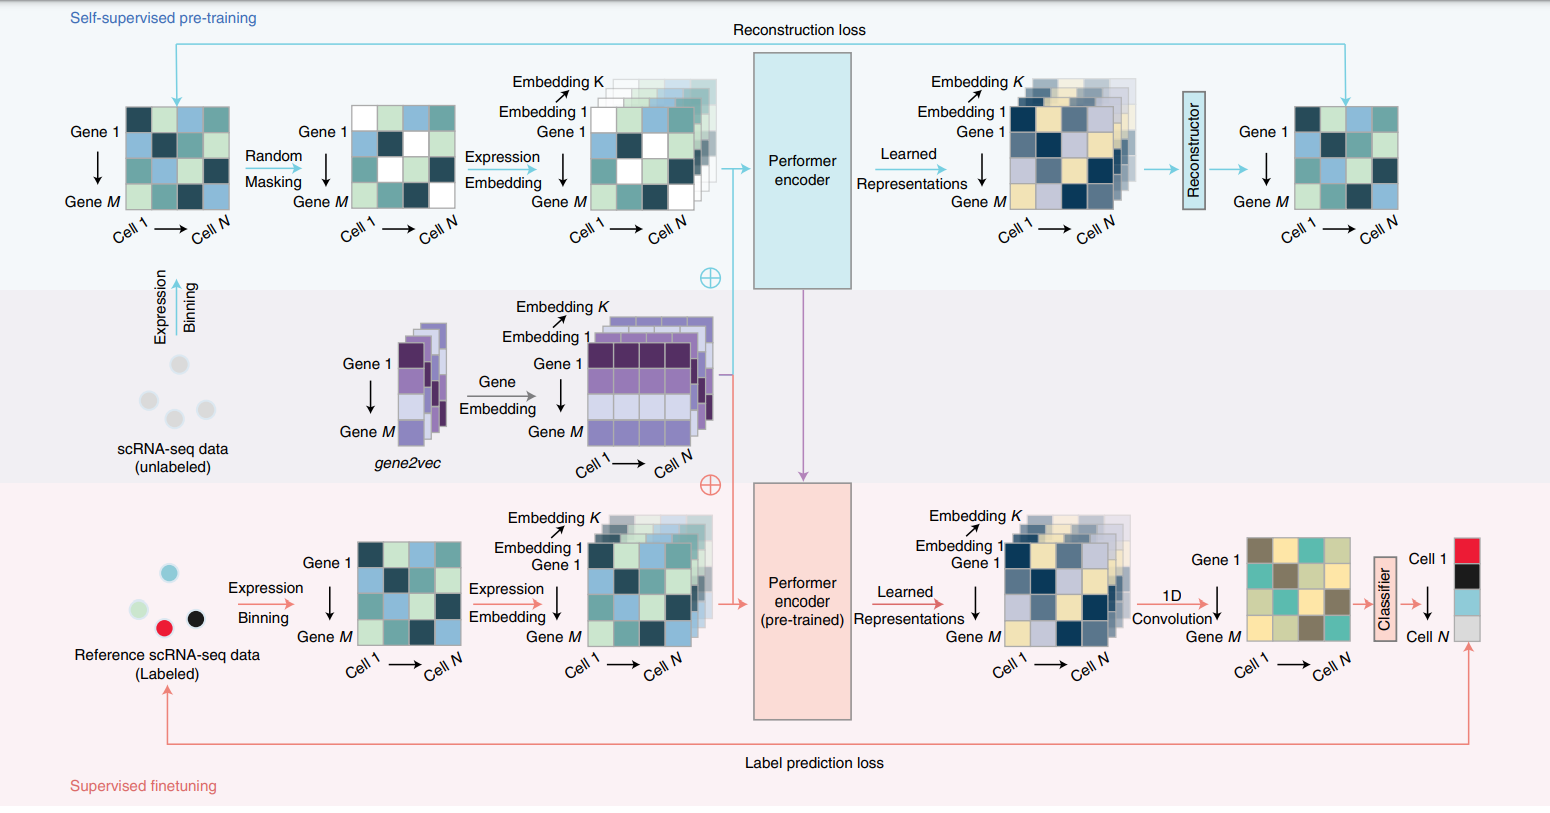

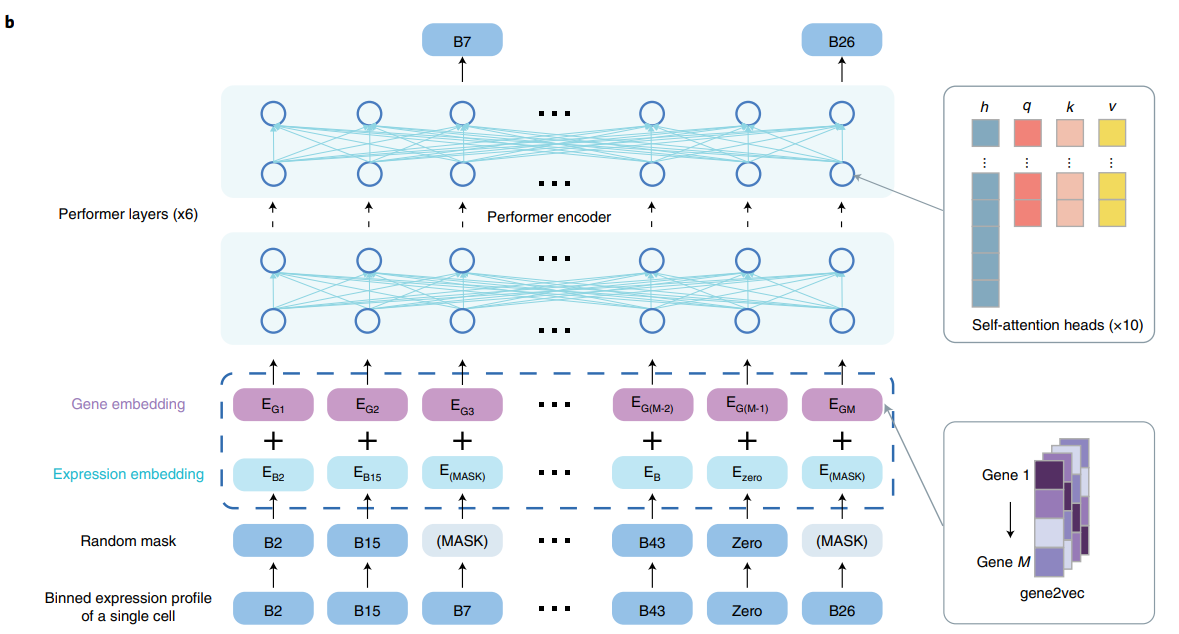

# Gene2Vec - Positional Embedding

Absolute positional Embedding - We won't use it here as scRNA data is position invariant

In [22]:
class Gene2VecPositionalEmbedding(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # size: (16906, 200)
        gene2vec_weight = np.load('../data/gene2vec_16906.npy') 
        # size: (16907, 200) , [-1] = [0 * 200]
        gene2vec_weight = np.concatenate((gene2vec_weight, np.zeros((1, gene2vec_weight.shape[1]))), axis=0)
        gene2vec_weight = torch.from_numpy(gene2vec_weight)
        self.emb = nn.Embedding.from_pretrained(gene2vec_weight)

    def forward(self, x):
        t = torch.arange(x.shape[1], device=x.device)
        return self.emb(t)
    
# class AbosolutePositionalEmbedding(nn.Module):
    # def __init__(self, d_model, max_seq_len) -> None:
        # super().__init__()
        # self.emb = nn.Embedding(max_seq_len, d_model)
    # def forward(self, x):
        # t = torch.arange(x.shape[1], device=x.device)
        # return self.emb(t)

# Kernel Functions

In [ ]:
def softmax_kernel(data, projection_matrix, is_query, normalize_data=True, eps=1e-4, device=None):
    b, h , *_ = data.shape
    data_normalizer = (data.shape[-1] ** -0.25) if normalize_data else 1

    ratio = (projection_matrix.shape[0] ** -0.5)

    projection = repeat(projection_matrix, 'j d -> b h j d', b = b, h = h)
    projection = projection.type_as(data)

    data_dash = torch.einsum('...id,...jd->...ij', (data_normalizer * data), projection)
    
    diag_data = data ** 2
    diag_data = torch.sum(diag_data, dim=-1)
    diag_data = (diag_data / 2.0) * (data_normalizer ** 2)
    diag_data = diag_data.unsqueeze(dim=-1)
    if is_query:
        data_dash = ratio * (torch.exp(data_dash - diag_data - torch.max(data_dash, dim=-1, keepdim=True).values) + eps)
    else:
        data_dash = ratio * (torch.exp(data_dash - diag_data - torch.max(data_dash)) + eps)
    
    return data_dash.type_as(data)

In [ ]:
def generalized_kernel(data, *, projection_matrix, kernel_fn = nn.ReLU(), eps = 0.001, normalize_data = True, device = None):
    b, h, *_ = data.shape

    data_normalizer = (data.shape[-1] ** -0.25) if normalize_data else 1.

    if projection_matrix is None:
        return kernel_fn(data_normalizer * data) + eps

    projection = repeat(projection_matrix, 'j d -> b h j d', b = b, h = h)
    projection = projection.type_as(data)

    data_dash = torch.einsum('...id,...jd->...ij', (data_normalizer * data), projection)

    data_prime = kernel_fn(data_dash) + eps
    return data_prime.type_as(data)


# Performer

In [1]:
class PerformerBlock(nn.Module):
    def __init( self,
                d_model,                           # Size of the the token embedding vectors, in scBERT
                depth,                             # Number of layers
                heads,                             # Number of heads
                dim_head=64,                       # Dimension of head
                local_attention_heads=0,           # Number of local attention heads (Heads - num of 
                local_window_size=256,             # Local window_size of local_attention
                causal=False,                      # Autoregressive or not
                ff_mult = 4,                       # dim of intermediate features after attention / d
                nb_features = None,                # Number of random features, if not set, will defa
                feature_redraw_interval = 1000,    # How frequently to redraw the projection matrix, 
                reversible = False,                # Reversible layers - To save memory - This is fro
                ff_chunks = 1,                     # Chunk FeedForward Layer - This is inspired from 
                ff_glu = False,                    # Use GLU for FeedForward?
                ff_dropout = 0.,                   # Feedforward dropout
                attention_dropout =0.,             # Post attention dropout
                generalized_attention = False,     # Defaults to softmax approximation, but can be se
                kernel_fn = nn.ReLU(),             # The kernel function to be used, if generalized a
                use_scalenorm = False,             # Use scale norm, from 'Transformers without Tears
                use_rezero = False,                # Use Rezero or not, from 'Rezero is all you need'
                cross_attend = False,              #   
                no_projection = False,             # 
                auto_check_redraw = True,          # 
                qkv_bias = False                   # bias layer for query, key, value
            ):
        super().__init__()
        layers = nn.ModuleList([])
        local_attention_heads = tuple(local_attention_heads)
        local_attention_heads = local_attention_heads * depth if len(local_attention_heads) == 1 else local_attention_heads
        assert len(local_attention_heads) == depth, 'tuple specifying number of local attention heads per depth must be equal to the total depth'
        assert all(map(lambda n: n >= 0 and n <= heads, local_attention_heads)), 'local attention head value must be less than the total number of heads'
        
        wrapper_fn = partial(PreLayerNorm, d_model)

        for _, local_heads in zip(range(depth), local_attention_heads):
            layers.append(
                nn.ModuleList([
                    wrapper_fn(),
                    wrapper_fn()
                ]))
            # If cross_attend is not needed, begin next cycle
            if not cross_attend:
                continue
            layers.append(nn.ModuleList([
                wrapper_fn()
                wrapper_fn()
            ]))
        
        # This section is for 
        execute_type = ReversibleSequence if reversible else SequentialSequence
        route_attention = ((True, False),) * depth * (2 if cross_attend else 1)
        route_context = ((False, False),(True, False)) * depth
        attention_route_map = {'mask': route_attention, 'pos_emb': route_attention}
        context_route_map = {'context': route_context, 'context_mask': route_context} if cross_attend else {}
        self.net = execute_type(layers, args_route = {**attention_route_map, **context_route_map})

        # Keeping track of when to redraw projections for all attention layers
        self.auto_check_redraw = auto_check_redraw
        self.feature_redraw_interval = feature_redraw_interval
        self.register_buffer('calls_since_last_redraw', torch.tensor(0))
    
    def fix_projection_matrices_(self):
        self.feature_redraw_interval = None
    
    def check_redraw_projections(self):
        if not self.training:
            return

        if exists(self.feature_redraw_interval) and self.calls_since_last_redraw >= self.feature_redraw_interval:
            device = device

            fast_attentions = find_modules(self, FastAttention)
            for fast_attention in fast_attentions:
                fast_attention.redraw_projection_matrix(device)
            self.calls_since_last_redraw.zero_()
            return
        
        self.calls_since_last_redraw += 1
        
    def forward(self,x, output_attentions=False, **kwargs):
        if self.auto_check_redraw:
            self.check_redraw_projections()
        return self.net()

NameError: name 'nn' is not defined

In [ ]:
class Performer(nn.Module):
    def __init__(self, 
                 d_model,                           # Size of the the token embedding vectors, in scBERT paper, this is dim
                 max_seq_len,                       # Max length of sequence
                 num_tokens,                        # Current Sequence Length
                 depth,                             # Number of layers
                 heads,                             # Number of heads
                 emb_dropout=0,                     # Dropout value for embedding layer
                 dim_head=64,                       # Dimension of head
                 local_attention_heads=0,           # Number of local attention heads (Heads - num of local attention heads) = number of global performers
                 local_window_size=256,             # Local window_size of local_attention
                 causal=False,                      # Autoregressive or not
                 ff_mult = 4,                       # dim of intermediate features after attention / dim of input features to FeedForward Block
                 nb_features = None,                # Number of random features, if not set, will default to (d * log(d))
                 feature_redraw_interval = 1000,    # How frequently to redraw the projection matrix, the more frequent, the slower the training
                 reversible = False,                # Reversible layers - To save memory - This is from Reformer 
                 ff_chunks = 1,                     # Chunk FeedForward Layer - This is inspired from Reformer
                 ff_glu = False,                    # Use GLU for FeedForward?
                 ff_dropout = 0.,                   # Feedforward dropout
                 attention_dropout =0.,             # Post attention dropout
                 generalized_attention = False,     # Defaults to softmax approximation, but can be set to True for generalized attention
                 kernel_fn = nn.ReLU(),             # The kernel function to be used, if generalized attention is turned on, defaults to ReLU
                 use_scalenorm = False,             # Use scale norm, from 'Transformers without Tears' paper, a substitute for LayerNorm, priority: scalenorm.rezero.layernorm
                 use_rezero = False,                # Use Rezero or not, from 'Rezero is all you need' paper, a substitute for LayerNorm, priority: scalenorm.rezero.layernorm
                 cross_attend = False,              #   
                 no_projection = False,             # 
                 tie_embed = False,                 # False: output is num of tokens, True: output is dim of tokens - (multiply final embeddings with token weights for logits, like gpt decoder)
                 g2v_position_emb = True,           # Apply gene2vec embedding or no embedding - I'm not implementing it here as we won't be needing no embedding
                 auto_check_redraw = True,          # 
                 qkv_bias = False                   # bias layer for query, key, value
                 ):
        
        self.max_seq_len = max_seq_len
        self.pos_emb = Gene2VecPositionalEmbedding()
        self.token_emb = nn.Embedding(num_tokens, d_model)
        self.dropout = nn.Dropout(emb_dropout)
        local_attention_heads = tuple(local_attention_heads) # Converts a number to tuple
        self.performerblock = PerformerBlock()
        self.norm = nn.LayerNorm(d_model)
        self.layer_pos_emb = Always(None)

    def check_redraw_projections(self):
        self.performerblock.check_redraw_projections()
    
    def fix_projection_matrices(self):
        self.performerblock.fix_projection_matrices_()
    
    def forward(self, 
                x,                          # Input
                return_encodings=False,     #
                output_attentions=False,    #
                **kwargs,                   #
                ):
        b, n, device = *x.shape, x.device   #
        assert n<= self.max_seq_len, f'sequence length {n} must be less than {self.max_seq_len}' 
        
        # Token and Positional Embedding Layers
        x = self.token_emb(x) 
        if output_attentions: 
                x.requires_grad_()
        x += self.pos_emb(x)
        x = self.dropout(x)

        # Performer Layers
        layer_pos_emb = self.layer_pos_emb(x)
        if output_attentions:
             x, attention_weights = self.performerblock()
             x = self.norm(x)
             if return_encodings:
                  return x, attention_weights
             if exists(self.to_out):
                  return self.to_out(x), attention_weights
             return (x @ self.token_emb.weight.t()), attn_weights
        else:
             x = self.performerblock()
             x = self.norm(x)

             if exists(self.to_out):
                  x = self.to_out(x)
                  return x
             return x @ self.token_emb.weight.t()
